In [55]:
%matplotlib inline

## Load and process the CSV file

All of the code until the next header is there to put the data into a more usable form for generating models. The end result is an array of games:

```
[game, game, game]
```

where each game is:

```
{
 id : 'you should not bother with this', # This is just an internal detail to group data.
 drives : [drive, drive, drive],
 scores : { 'TEAM1': 12, 'TEAM2': 19 }, # The final score, calculated by adding up plays in the game.
 winner : 'TEAM2', # The winner, either determined by the ScoreDiff in the data or the scores.
}
```

where each drive is:

```
{
 result : 7, # Could be -8, -7, -2, 0, 2, 3, 7, 8, negative numbers mean the defense scored.
 possessing_team: 'TEAM2', # The team which is on offense during this drive
 situations : [situation, situation situation],
}
```

and then every situation looks like:

```
{
  'down': , # One of 1, 2, 3 or 4.
  'time' : 1548, # Seconds left in regulation, so it starts at 3600. Overtime has negative values.
  'distance_to_goal' : 55, # 1 for a yard to a goal, 99 for being on the other side.
  'yards_to_first_down' : 13, # Number of yards for a first down.
  'score_differential' : -7, # The lead of the driving team, basically the "ScoreDiff" column.
  'scores' : { 'TEAM1': 12, 'TEAM2': 5 }
}
```


In [56]:
import csv, itertools
from copy import deepcopy

In [57]:
# There isn't always an extra point recorded after a touchdown. Often after an interception or a fumble
# that was run back, things get weird. By looking at the play immediately after the touchdown, if there isn't a
# play explicitly recorded, then assume that it was an extra point kick which was good.
def determine_post_touchdown_play(row):
    if row['ExPointResult'] == 'Made':
        return 1
    elif row['ExPointResult'] == 'Missed':
        return 0
    elif row['TwoPointConv'] == 'Success':
        return 2
    elif row['TwoPointConv'] == 'Failure':
        return 0
    elif row['DefTwoPoint'] == 'Success':
        # Basically the Saints vs Broncos game where the blocked an XP at the end of the game.
        return -2
    else:
        # print('Had trouble determining the post touchdown result on this play: ' + row['desc'])
        return 1

def cleanup_time(time_string):
    if time_string == '2e3':
        return '2000'
    elif time_string == '1e3':
        return '1000'
    elif time_string == '3e3':
        return '3000'
    return time_string

def determine_winning_team(row):
    score_diff = int(row['ScoreDiff'])
    winner_from_score_diff = None
    if score_diff == 0:
        winner_from_score_diff = 'nobody'
    elif score_diff < 0:
        winner_from_score_diff = row['DefensiveTeam']
    else:
        winner_from_score_diff = row['posteam']
    return winner_from_score_diff

def determine_winning_team_from_scores(scores):
    winner_from_scores = None
    if scores[row['HomeTeam']] == scores[row['AwayTeam']]:
        winner_from_scores = 'nobody'
    elif scores[row['HomeTeam']] > scores[row['AwayTeam']]:
        winner_from_scores = row['HomeTeam']
    else:
        winner_from_scores = row['AwayTeam']
    return winner_from_scores

# Holy moly this is a mess, but so is the data.
# If there is a touchdown, peek ahead and see if there is a two point conversion attempt or an extra point attempt.
# Frequently the play after a touchdown is missing, so we do our best and assume an extra point was kicked. This
# doesn't work very well in some games, like the Snow Bowl game between the Lions and Eagles, where there were two
# two point conversion attempts that failed and don't have an entry. This results in a final score of 34-22, which
# should be 34-20.
# TODO(andrew): Rework this so that it doesn't have side effects.
def get_points(row, next_row, reader1, reader2):
    if row['sp'] != '1':
        return (0, row, next_row)
    if row['Touchdown'] == '1':
        points = 6
        # If a game ends on a touchdown in overtime, then it moves right into the next game
        # and there is no end of game marker or missing extra point play. Sometimes the extra
        # point play is missing and it moves right to the next game.
        if next_row is not None and row['GameID'] == next_row['GameID']:
            # Peek ahead to the next valid play, skipping ones where penalties occurred
            row = next(reader1)
            # Advance both of them, so they don't get out of sync.
            next_row = next(reader2)
            while row['PlayType'] == 'No Play' or row['PlayType'] == 'Timeout':
                row = next(reader1)
                next_row = next(reader2)
            next_points = determine_post_touchdown_play(row)
            points = points + next_points
        # Let's check and see if this was an interception or a fumble run back for a TD
        # A return result of TouchDown can also be from a punt or kickoff.
        if row['ReturnResult'] == 'Touchdown' and row['PlayType'] != 'Kickoff':
            return (-1 * points, row, next_row)
        return (points, row, next_row)
    elif row['Safety'] == '1':
        return (-2, row, next_row)
    elif row['FieldGoalResult'] == 'Good':
        return (3, row, next_row)
    else:
        if debug:
            print('unable to determine points for scoring play')
            print(row['desc'])
            print(row['FieldGoalResult'])
        return (1, row, next_row)

# Stands for "pretty print row" in case you were wondering.
def ppr(row):
    print('Game: {}, Drive: {}, Down: {}, '
          'Yards To Goal: {}, ScoreDiff: {}, '
          'PosTeam: {}, DefTeam: {},\nDesc: {}'.format(
          row['GameID'], row['Drive'], row['down'],
          row['yrdline100'], row['ScoreDiff'],
          row['posteam'], row['DefensiveTeam'], row['desc']))

In [58]:
## Types of games here:
## Tampa Bay / Minnesota was a game where the *first* play of overtime is a fumble run back for a touchdown
#f = open('picksix.csv', 'r')
f = open('nfl_play_by_play_2009_2016.csv', 'r')
reader = csv.DictReader(f)

debug = False
debug_lots = False
filter_to_games = []

games = []
current_game = None
current_drive = None
ignored = 0
total = 0
last_row = None
reader1, reader2 = itertools.tee(csv.DictReader(f))
next(reader2)
for row, next_row in itertools.zip_longest(reader1, reader2):
    total = total + 1
    # So we ignore plays with this content, they seem to be meaningless
    if row['desc'] == '*** play under review ***':
        ignored = ignored + 1
        continue

    if len(filter_to_games) > 0 and row['GameID'] not in filter_to_games:
        ignored = ignored + 1
        continue

    if debug_lots:
        ppr(row)

    # Indicates either it's the first row in the file, or it's the first row
    # of a new drive.
    if current_game is None:
        if debug:
            print('START OF GAME {}, {} @ {}'.format(row['GameID'], row['AwayTeam'],row['HomeTeam']))
        current_game = {
            'id': row['GameID'],
            'drives': [],
            'scores': {
                row['HomeTeam']: 0,
                row['AwayTeam']: 0,
            },
        }

    # Indicates either it's the first row in the file, or it's the first row
    # of a new drive.
    if current_drive is None:
        if debug:
            print('--> START OF DRIVE {}'.format(row['Drive']))
        current_drive = {
            'id': row['Drive'],
            'possessing_team': row['posteam'],
            'situations': [],
        }
    
    if row['down'] != 'NA':
        situation_at_start_of_play = {
            'down': int(row['down']),
            'time': int(cleanup_time(row['TimeSecs'])),
            'distance_to_goal': int(row['yrdline100']),
            'yards_to_first_down': int(row['ydstogo']),
            'score_differential': int(row['ScoreDiff']),
            'scores': deepcopy(current_game['scores']),
        }
        current_drive['situations'].append(situation_at_start_of_play)

    # Our attempt at keeping track of the points, since the ScoreDiff isn't always right.
    points, row, next_row = get_points(row, next_row, reader1, reader2)
    if points > 0:
        current_game['scores'][row['posteam']] = current_game['scores'][row['posteam']] + points
    elif points < 0:
        current_game['scores'][row['DefensiveTeam']] = current_game['scores'][row['DefensiveTeam']] - points

    # Constantly keep track of what the current winner is, because sometimes the final row for a game has the
    # score differential, sometimes it doesn't. ¯\_(ツ)_/¯
    if row['ScoreDiff'] != 'NA':
        current_game['winner'] = determine_winning_team(row)

    current_game['winner_scores'] = determine_winning_team_from_scores(current_game['scores'])

    # If it's the end of the game, reset the game and drive.
    # Sometimes we have an "End of Game" play, sometimes the game just ends,
    # and there is always the last game in the file. Sometimes there are two 
    # end of game plays. ¯\_(ツ)_/¯
    if row['PlayType'] == 'End of Game' \
            or next_row is None \
            or next_row['GameID'] != current_game['id']:
        # Sometimes we get two 'end of game' plays. If this is the case, just advance both readers
        if next_row is not None and next_row['PlayType'] == 'End of Game':
            ignored = ignored + 1
            next(reader1), next(reader2)
        current_drive['points'] = points
        if debug:
            print('--> END OF DRIVE {}, resulting in {} points'.format(current_drive['id'], current_drive['points']))
        current_game['drives'].append(current_drive)
        current_drive = None

        games.append(current_game)
        if debug:
            print('END OF GAME {}, winner is {} scores are {}'.format(
                current_game['id'], current_game['winner'], current_game['scores']))
        current_game = None
        continue
    
    # This was the last play in the drive, either scoring or not
    if current_drive['id'] != next_row['Drive']:
        current_drive['points'] = points
        current_game['drives'].append(current_drive)
        if debug:
            print('--> END OF DRIVE {}, resulting in {} points'.format(current_drive['id'], current_drive['points']))
        current_drive = None

# Record the last drive for the last game
if current_drive is not None and len(current_drive['situations']) > 0:
    current_drive['points'] = 0
    current_game['drives'].append(current_drive)
    games.append(current_game)
    #print('end of game {}, winner is {} scores are {}'.format(current_game['id'], current_game['winner'], current_game['scores']))
    if current_game['winner'] != current_game['winner_scores']:
        print('I thought {} won the game, but scorediff thinks that {} won the game'.format(current_game['winner_scores'], current_game['winner']))

print('ignored ' + str(ignored) + ' rows of ' + str(total) + ' total ' + str(total - ignored) + ' observations')

ignored 214 rows of 351897 total 351683 observations


In [59]:
rows = []
print(len(games))
for game in games:
    for drive in game['drives']:
        for situation in drive['situations']:
            rows.append(situation)

print(len(rows))

2049
308080


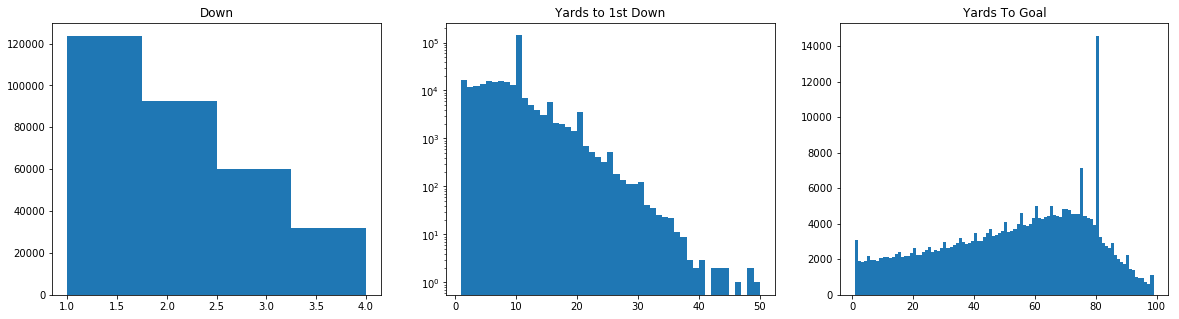

In [60]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

downs = list(map(lambda row: row['down'], rows))
downs_hist = axes[0].hist(downs, 4)
axes[0].set_title('Down')

yardstogo = list(map(lambda row: row['yards_to_first_down'], rows))
ytg_hist = axes[1].hist(yardstogo, bins=np.linspace(min(yardstogo), max(yardstogo), max(yardstogo)), log=True)
axes[1].set_title('Yards to 1st Down')

yardstogoal = list(map(lambda row: row['distance_to_goal'], rows))
ytg_hist = axes[2].hist(yardstogoal, bins=np.linspace(min(yardstogoal), max(yardstogoal), max(yardstogoal)), log=False)
axes[2].set_title('Yards To Goal')


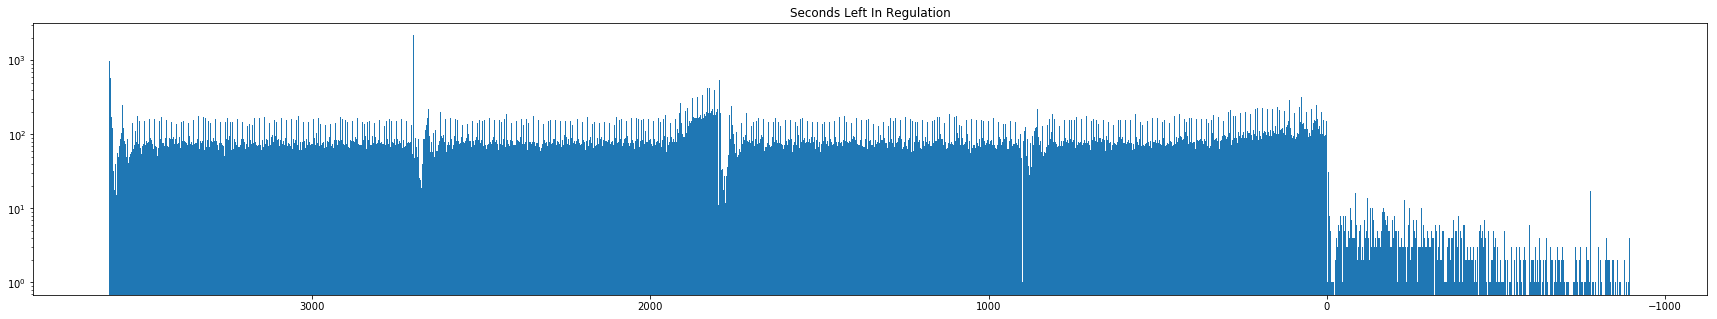

In [61]:
time_remaining = list(map(lambda row: row['time'], rows))
plt.figure(figsize=(30, 5))
plt.title('Seconds Left In Regulation')
plt.gca().invert_xaxis()
time_remaining_hist = plt.hist(time_remaining,
                               bins=np.linspace(min(time_remaining), max(time_remaining), max(time_remaining)),
                               log=True)
# time_remaining_hist.set_title('Time Left')

time_remaining = plt = time_remaining_hist = None

## Rate of Play

You can see at the end of the half and at the end of the game the rate of plays pick up. The beginning of the each quarter sees some very slow plays.

## Expected Points GLM

How should we create GLM inputs for Expected Points? Should we bucket them?

Time should probably be the amount of time left in regulation. Overtime is nice and all but I'm happy to not model it.

Down should be crossed with yards to 1st down, probably. The yardage becomes more and more important as you approach fourth down.



In [62]:
import pandas as pd
import statsmodels.api as sm

glm_rows = []
for game in games:
    for drive in game['drives']:
        first_downs = 0
        for situation in drive['situations']:
            glm_row = deepcopy(situation)
            glm_row['points'] = drive['points']
            glm_row['is_first_down'] = 1 if glm_row['down'] == 1 else 0
            glm_row['is_second_down'] = 1 if glm_row['down'] == 2 else 0
            glm_row['is_third_down'] = 1 if glm_row['down'] == 3 else 0
            glm_row['is_over_10_yards_to_first_down'] = 1 if glm_row['yards_to_first_down'] > 10 else 0
            glm_row['is_field_goal_range'] = 1 if glm_row['distance_to_goal'] <= 35 else 0
            if glm_row['down'] == 1:
                first_downs = first_downs + 1
            glm_row['first_downs'] = first_downs
            del glm_row['down']
            del glm_row['scores']
            del glm_row['score_differential']
            glm_rows.append(glm_row)

row_data_frame = pd.DataFrame.from_dict(glm_rows)
glm_rows = None
row_data_frame.describe(include = 'all')

/Users/andrewstromberg/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,distance_to_goal,first_downs,is_field_goal_range,is_first_down,is_over_10_yards_to_first_down,is_second_down,is_third_down,points,time,yards_to_first_down
count,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000,308080.000000
mean,52.481060,2.301009,0.268654,0.401237,0.125062,0.300383,0.194229,2.328509,1725.226753,8.589938
std,24.693821,1.424043,0.443260,0.490150,0.330789,0.458425,0.395606,2.914985,1056.847840,4.095384
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,-899.000000,1.000000
25%,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,816.000000,6.000000
50%,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1795.000000,10.000000
75%,73.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2620.000000,10.000000
max,99.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,3600.000000,50.000000


In [134]:
res = sm.formula.glm('points ~ '
                     'distance_to_goal + yards_to_first_down + is_first_down + is_second_down + is_third_down'
                     '+ first_downs'
                     '+ is_over_10_yards_to_first_down'
                     '+ is_field_goal_range'
                     '+ yards_to_first_down : is_first_down'
                     '+ yards_to_first_down : is_second_down'
                     '+ yards_to_first_down : is_third_down',
                     family=sm.families.Gaussian(), 
                     data=row_data_frame).fit() 

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 points   No. Observations:               308080
Model:                            GLM   Df Residuals:                   308068
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                   6.81960773125
Method:                          IRLS   Log-Likelihood:            -7.3287e+05
Date:                Mon, 02 Oct 2017   Deviance:                   2.1009e+06
Time:                        10:49:19   Pearson chi2:                 2.10e+06
No. Iterations:                     2                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              2.2117      0.037     59.039      0.000       2.138       2.285
distance_to_goal                      -0.0309      0.000    -79.883      0.000      -0.032      -0.030
yards_to_first_down                   -0.0155      0.003     -5.311      0.000      -0.021      -0.010
is_first_down                          2.6305      0.044     59.700      0.000       2.544       2.717
is_second_down                         2.0942      0.031     68.281      0.000       2.034       2.154
is_third_down                          1.5176      0.031     49.180      0.000       1.457       1.578
first_downs                            0.0621      0.005     13.238      0.000       0.053       0.071
is_over_10_yards_to_first_down         0.1068      0.022      4.938      0.000       0.064       0.149
is_field_goal_range                    0.7247      0.019     39.042      0.000       0.688       0.761
yards_to_first_down:is_first_down     -0.0622      0.004    -14.280      0.000      -0.071      -0.054
yards_to_first_down:is_second_down    -0.0543      0.003    -16.566      0.000      -0.061      -0.048
yards_to_first_down:is_third_down     -0.0563      0.003    -16.803      0.000      -0.063      -0.050
======================================================================================================
"""

In [152]:
# Make a model with just the important things
res = sm.formula.glm('points ~ '
                     'distance_to_goal + yards_to_first_down + is_first_down + is_second_down + is_third_down',
                     family=sm.families.Gaussian(), 
                     data=row_data_frame).fit() 

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 points   No. Observations:               308080
Model:                            GLM   Df Residuals:                   308074
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                   6.86690276949
Method:                          IRLS   Log-Likelihood:            -7.3393e+05
Date:                Mon, 02 Oct 2017   Deviance:                   2.1155e+06
Time:                        11:45:29   Pearson chi2:                 2.12e+06
No. Iterations:                     2                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.5263      0.019    185.618      0.000       3.489       3.564
distance_to_goal       -0.0445      0.000   -226.633      0.000      -0.045      -0.044
yards_to_first_down    -0.0471      0.001    -38.192      0.000      -0.049      -0.045
is_first_down           2.0722      0.017    124.450      0.000       2.040       2.105
is_second_down          1.6599      0.017     97.747      0.000       1.627       1.693
is_third_down           1.0870      0.018     59.915      0.000       1.051       1.123
=======================================================================================
"""

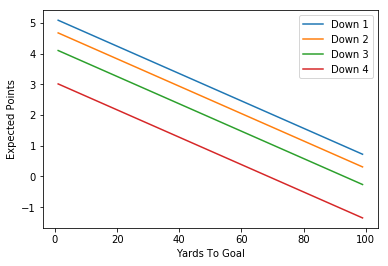

In [153]:
import matplotlib.pyplot as plt

yard_lines = range(99, 0, -1)

expected_points = {}
for d in range(0, 4):
    down = d + 1
    values = []
    for i in yard_lines:
        values.append({
            'distance_to_goal' : i,
            'yards_to_first_down': 10,
            'is_first_down': 1 if down == 1 else 0,
            'is_second_down': 1 if down == 2 else 0,
            'is_third_down': 1 if down == 3 else 0,
        })
    to_predict = pd.DataFrame.from_dict(values)
    expected_points[down] = res.predict(exog=to_predict)

for d in range(0, 4):
    down = d + 1
    plt.plot(yard_lines, expected_points[down], label='Down {}'.format(down))
    plt.legend(loc='best')
    plt.xlabel('Yards To Goal')
    plt.ylabel('Expected Points')


In [173]:
# Converts tha couple of games into a game friendly csv format

games_to_output = ['2009091304', '2016103000', '2013120800', '2013120805']
game_output = {}
for game_id in games_to_output:
    game_output[game_id] = ''
for row in csv.DictReader(open('nfl_play_by_play_2009_2016.csv', 'r')):
    # So we ignore plays with this content, they seem to be meaningless
    if row['desc'] == '*** play under review ***' or row['GameID'] not in games_to_output or row['down'] == 'NA':
        continue
    game_output[row['GameID']] = game_output[row['GameID']] + '[{}, {}, {}, {}, {}, {}, \'{}\'], '.format(
            int(cleanup_time(row['TimeSecs'])),
            int(row['ScoreDiff']),
            int(row['yrdline100']),
            int(row['ydstogo']),
            int(row['down']),
            1 if row['posteam'] == row['HomeTeam'] else 0,
            row['posteam'])

for game_id in games_to_output:
    print('[')
    print(game_output[game_id], end='')
    print('\n],')

[
[3599, 0, 51, 10, 1, 1, 'CLE'], [3559, 0, 45, 4, 2, 1, 'CLE'], [3553, 0, 45, 4, 3, 1, 'CLE'], [3515, 0, 40, 10, 1, 1, 'CLE'], [3469, 0, 22, 10, 1, 1, 'CLE'], [3465, 0, 22, 10, 2, 1, 'CLE'], [3429, 0, 21, 9, 3, 1, 'CLE'], [3393, 0, 20, 8, 4, 1, 'CLE'], [3381, -3, 70, 10, 1, 0, 'MIN'], [3345, -3, 69, 9, 2, 0, 'MIN'], [3304, -3, 69, 9, 3, 0, 'MIN'], [3273, -3, 70, 10, 4, 0, 'MIN'], [3264, 3, 78, 10, 1, 1, 'CLE'], [3229, 3, 76, 8, 2, 1, 'CLE'], [3197, 3, 84, 16, 2, 1, 'CLE'], [3155, 3, 82, 14, 3, 1, 'CLE'], [3125, 3, 82, 14, 4, 1, 'CLE'], [3115, -3, 49, 10, 1, 0, 'MIN'], [3081, -3, 43, 4, 2, 0, 'MIN'], [3045, -3, 40, 1, 3, 0, 'MIN'], [3010, -3, 33, 10, 1, 0, 'MIN'], [2971, -3, 37, 14, 2, 0, 'MIN'], [2928, -3, 24, 1, 3, 0, 'MIN'], [2887, -3, 19, 10, 1, 0, 'MIN'], [2837, -3, 14, 5, 2, 0, 'MIN'], [2793, -3, 3, 3, 1, 0, 'MIN'], [2755, -3, 1, 1, 2, 0, 'MIN'], [2710, -3, 3, 3, 3, 0, 'MIN'], [2706, -3, 3, 3, 4, 0, 'MIN'], [2700, 0, 86, 10, 1, 1, 'CLE'], [2664, 0, 86, 10, 2, 1, 'CLE'], [2617, 0,